In [1]:
import os
import math
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Optional: if PyTorch is available we implement BiLSTM+Attention
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

In [4]:
# ---------- User-editable paths ----------
TWEET_CSV = '/content/tweet_features.csv'   # change if needed
USER_CSV  = '/content/user_features.csv'    # change if needed
EDGES_CSV = '/mnt/data/propagation_edges.csv' # optional: edges with columns src_id,dst_id,timestamp,tweet_id
LABEL_COL = None  # if you know the label column name in merged df, set it here (e.g., 'label')
TEXT_COL  = None  # if you have raw tweet text column name in the tweet CSV, set it here (e.g., 'text')

In [5]:
# ---------- Utility functions ----------
def load_data(tweet_csv, user_csv):
    """Load and merge tweet + user CSVs on tweet_id. Returns merged df."""
    print("Loading datasets...")
    df_t = pd.read_csv(tweet_csv)
    df_u = pd.read_csv(user_csv)
    # unify column whitespace
    df_t.columns = [c.strip() for c in df_t.columns]
    df_u.columns = [c.strip() for c in df_u.columns]
    # merge
    df = pd.merge(df_t, df_u, on='tweet_id', how='inner')
    print(f"Merged dataframe shape: {df.shape}")
    return df

In [6]:
def infer_label_column(df, label_col_hint=None):
    """Find label column or create synthetic label."""
    if label_col_hint and label_col_hint in df.columns:
        print(f"Using provided label column: {label_col_hint}")
        return label_col_hint, df[label_col_hint].values
    # search for likely label column names
    for cand in ['label', 'is_misinformation', 'misinfo', 'target', 'stance', 'truth_label', 'y']:
        if cand in df.columns:
            print(f"Using detected label column: {cand}")
            return cand, df[cand].values
    # otherwise create a synthetic label (transparent heuristic)
    print("No label column detected. Creating synthetic label 'label_synth' using heuristic.")
    # safe-guard column names
    for c in ['num_negsentiwords','num_URLs','num_hashtags','num_retweets']:
        if c not in df.columns and (' '+c) in df.columns:
            df[c] = df[' '+c].fillna(0)
    df['num_negsentiwords'] = df.get('num_negsentiwords', df.get('num_negsentiwords', 0)).fillna(0).astype(float)
    df['num_URLs'] = df.get('num_URLs', 0).fillna(0).astype(float)
    df['num_hashtags'] = df.get('num_hashtags', 0).fillna(0).astype(float)
    df['num_retweets'] = df.get('num_retweets', 0).fillna(0).astype(float)
    df['label_synth'] = (
        (df['num_negsentiwords'] >= 2).astype(int) |
        ((df['num_URLs'] >= 2) & (df['num_hashtags'] >= 3)).astype(int) |
        (df['num_retweets'] > 5).astype(int)
    ).astype(int)
    print("Synthetic label distribution:\n", df['label_synth'].value_counts().to_dict())
    return 'label_synth', df['label_synth'].values

In [7]:
def detect_text_column(df, hint=None):
    if hint and hint in df.columns:
        return hint
    # common names
    for cand in ['text','tweet_text','content','tweet','message']:
        if cand in df.columns:
            return cand
    return None

# Simple PyTorch BiLSTM + Attention

In [8]:
if TORCH_AVAILABLE:
    class TextDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_len=64):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_len = max_len
        def __len__(self): return len(self.texts)
        def __getitem__(self, idx):
            toks = self.tokenizer(self.texts[idx])
            # pad/truncate tokens to max_len
            if len(toks) < self.max_len:
                toks = toks + [0]*(self.max_len - len(toks))
            else:
                toks = toks[:self.max_len]
            return torch.tensor(toks, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [9]:
class SimpleBiLSTMAttn(nn.Module):
        def __init__(self, vocab_size, emb_dim=64, hid_dim=64, n_layers=1, dropout=0.3):
            super().__init__()
            self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers,
                                batch_first=True, bidirectional=True, dropout=dropout if n_layers>1 else 0.0)
            self.attn_w = nn.Linear(hid_dim*2, 1)
            self.fc = nn.Linear(hid_dim*2, 1)
            self.dropout = nn.Dropout(dropout)
        def forward(self, x):   # x: (B, L)
            emb = self.emb(x)   # (B, L, E)
            out, _ = self.lstm(emb)  # (B, L, 2H)
            # attention weights
            w = self.attn_w(out).squeeze(-1)   # (B, L)
            a = torch.softmax(w, dim=1).unsqueeze(-1)  # (B, L, 1)
            rep = (out * a).sum(dim=1)   # (B, 2H)
            rep = self.dropout(rep)
            logits = self.fc(rep).squeeze(-1)
            return logits, torch.sigmoid(logits)


In [10]:
# ---------- Feature selection ----------
def prepare_feature_groups(df):
    # naive heuristics: columns with 'num_' or 'contains' as text features; user features are user- prefixed columns
    cols = [c.strip() for c in df.columns]
    text_cols = [c for c in cols if c.startswith('num_') or 'contains' in c or 'text' in c or 'words' in c]
    user_cols = [c for c in cols if any(x in c for x in ('followers','friends','listed','verified','tweets','ratio','times_listed'))]
    # remove label & id columns
    text_cols = [c for c in text_cols if c not in ('tweet_id')]
    user_cols = [c for c in user_cols if c not in ('tweet_id')]
    # fallback: if lists empty, use numeric columns
    if not text_cols:
        text_cols = [c for c in cols if df[c].dtype in [int,float] and c not in ('tweet_id')]
    if not user_cols:
        user_cols = []
    combined = text_cols + user_cols
    # unique
    text_cols = list(dict.fromkeys(text_cols))
    user_cols = list(dict.fromkeys(user_cols))
    combined = list(dict.fromkeys(combined))
    print("Detected feature groups sizes -> text:", len(text_cols), ", user:", len(user_cols), ", combined:", len(combined))
    return text_cols, user_cols, combined

In [11]:
# ---------- Models (proxies & training wrappers) ----------
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [12]:
def train_surrogate_models(X_train_text, X_train_user, X_train_comb, y_train):
    """Train surrogate models that approximate the existing models for tabular features."""
    print("Training surrogate models (for quick prototyping)...")
    scaler_t = StandardScaler().fit(X_train_text)
    scaler_u = StandardScaler().fit(X_train_user) if X_train_user.shape[1]>0 else None
    scaler_c = StandardScaler().fit(X_train_comb)
    Xt_train_s = scaler_t.transform(X_train_text)
    Xu_train_s = scaler_u.transform(X_train_user) if scaler_u is not None else np.zeros((X_train_text.shape[0],0))
    Xc_train_s = scaler_c.transform(X_train_comb)
    # models
    model_bilstm = RandomForestClassifier(n_estimators=200, random_state=42)  # surrogate for BiLSTM
    model_gcn = GradientBoostingClassifier(n_estimators=200, random_state=42) # surrogate for GCN
    model_tgn = RandomForestClassifier(n_estimators=200, random_state=7)     # surrogate for TGN
    model_mmt = LogisticRegression(max_iter=1000, random_state=0)           # surrogate for MMT
    # fit
    model_bilstm.fit(Xt_train_s, y_train)
    if Xu_train_s.shape[1] > 0:
        model_gcn.fit(Xu_train_s, y_train)
    else:
        model_gcn = None
    model_tgn.fit(Xt_train_s, y_train)
    model_mmt.fit(Xc_train_s, y_train)
    # ensemble as proposed model prototype
    estimators = [('bilstm', model_bilstm)]
    if model_gcn: estimators.append(('gcn', model_gcn))
    estimators += [('tgn', model_tgn), ('mmt', model_mmt)]
    ensemble = VotingClassifier(estimators=estimators, voting='soft')
    # simple augmentation - ablate random features in combined features to mimic counterfactual robustness
    X_aug = Xc_train_s.copy()
    rng = np.random.RandomState(42)
    n_rows, n_cols = X_aug.shape
    for i in range(max(1, n_rows//5)):
        cols_idx = rng.choice(n_cols, size=max(1,int(0.1*n_cols)), replace=False)
        X_aug[i, cols_idx] = 0
    X_ensemble_train = np.vstack([Xc_train_s, X_aug])
    y_ensemble_train = np.concatenate([y_train, y_train[:X_aug.shape[0]]])
    ensemble.fit(X_ensemble_train, y_ensemble_train)
    scalers = {'text':scaler_t, 'user':scaler_u, 'combined':scaler_c}
    models = {'bilstm':model_bilstm, 'gcn':model_gcn, 'tgn':model_tgn, 'mmt':model_mmt, 'proposed':ensemble}
    return models, scalers

In [13]:
def evaluate_and_plot(models, scalers, X_test_text, X_test_user, X_test_comb, y_test, out_dir='outputs'):
    os.makedirs(out_dir, exist_ok=True)
    # scale
    Xt_s = scalers['text'].transform(X_test_text)
    Xu_s = scalers['user'].transform(X_test_user) if scalers['user'] is not None and X_test_user.shape[1]>0 else np.zeros((X_test_text.shape[0],0))
    Xc_s = scalers['combined'].transform(X_test_comb)
    preds = {}
    # get predictions (handle missing models)
    preds['BiLSTM_Attn (sim)'] = models['bilstm'].predict(Xt_s)
    preds['GCN (sim)'] = models['gcn'].predict(Xu_s) if models['gcn'] is not None else np.zeros_like(preds['BiLSTM_Attn (sim)'])
    preds['TGN (sim)'] = models['tgn'].predict(Xt_s)
    preds['MMT (sim)'] = models['mmt'].predict(Xc_s)
    preds['CTPP-GNN (proposed, sim)'] = models['proposed'].predict(Xc_s)
    # metrics
    metrics = {}
    for name, pred in preds.items():
        p, r, f, _ = precision_recall_fscore_support(y_test, pred, average='binary', zero_division=0)
        cm = confusion_matrix(y_test, pred)
        metrics[name] = {'precision':p, 'recall':r, 'f1':f, 'confusion_matrix':cm}
        print(f"\n{name}: Precision={p:.4f}, Recall={r:.4f}, F1={f:.4f}")
        print("Confusion matrix:\n", cm)
    # plot confusion matrices
    n = len(metrics)
    cols = 3
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.ravel()
    for i, (name, m) in enumerate(metrics.items()):
        sns.heatmap(m['confusion_matrix'], annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(name)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    # remove extra axes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    fig_path = os.path.join(out_dir, 'confusion_matrices.png')
    plt.savefig(fig_path)
    print(f"\nSaved confusion matrices figure to {fig_path}")
    # compute average existing CM and diff vs proposed
    existing_keys = [k for k in metrics.keys() if 'proposed' not in k.lower()]
    cms = np.array([metrics[k]['confusion_matrix'] for k in existing_keys])
    avg_cm = cms.mean(axis=0)
    prop_cm = metrics['CTPP-GNN (proposed, sim)']['confusion_matrix']
    diff_cm = avg_cm - prop_cm
    # plot diff heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(diff_cm, annot=True, fmt='.1f', center=0, cmap='coolwarm')
    plt.title('Avg(existing CM) - Proposed CM (positive => existing higher error)')
    diff_path = os.path.join(out_dir, 'cm_diff_heatmap.png')
    plt.savefig(diff_path)
    print(f"Saved CM difference heatmap to {diff_path}")
    # save metrics CSV
    summary = pd.DataFrame([{ 'model':name, 'precision':metrics[name]['precision'], 'recall':metrics[name]['recall'], 'f1':metrics[name]['f1']} for name in metrics])
    summary_path = os.path.join(out_dir, 'model_metrics_summary.csv')
    summary.to_csv(summary_path, index=False)
    print(f"Saved metrics summary to {summary_path}")
    return metrics, preds, {'confusion_figure':fig_path, 'diff_heatmap':diff_path, 'summary_csv':summary_path}

Loading datasets...
Merged dataframe shape: (14487, 26)
No label column detected. Creating synthetic label 'label_synth' using heuristic.
Synthetic label distribution:
 {0: 12192, 1: 2295}
No raw text column detected. BiLSTM (true) won't run; surrogate will be used.
Detected feature groups sizes -> text: 21 , user: 7 , combined: 24
Skipping full BiLSTM training (no raw text or torch). Using surrogates for everything.
Training surrogate models (for quick prototyping)...

BiLSTM_Attn (sim): Precision=1.0000, Recall=0.9930, F1=0.9965
Confusion matrix:
 [[3048    0]
 [   4  570]]

GCN (sim): Precision=0.9899, Recall=0.6847, F1=0.8095
Confusion matrix:
 [[3044    4]
 [ 181  393]]

TGN (sim): Precision=1.0000, Recall=0.9930, F1=0.9965
Confusion matrix:
 [[3048    0]
 [   4  570]]

MMT (sim): Precision=0.9495, Recall=0.6882, F1=0.7980
Confusion matrix:
 [[3027   21]
 [ 179  395]]

CTPP-GNN (proposed, sim): Precision=1.0000, Recall=0.9930, F1=0.9965
Confusion matrix:
 [[3048    0]
 [   4  570]

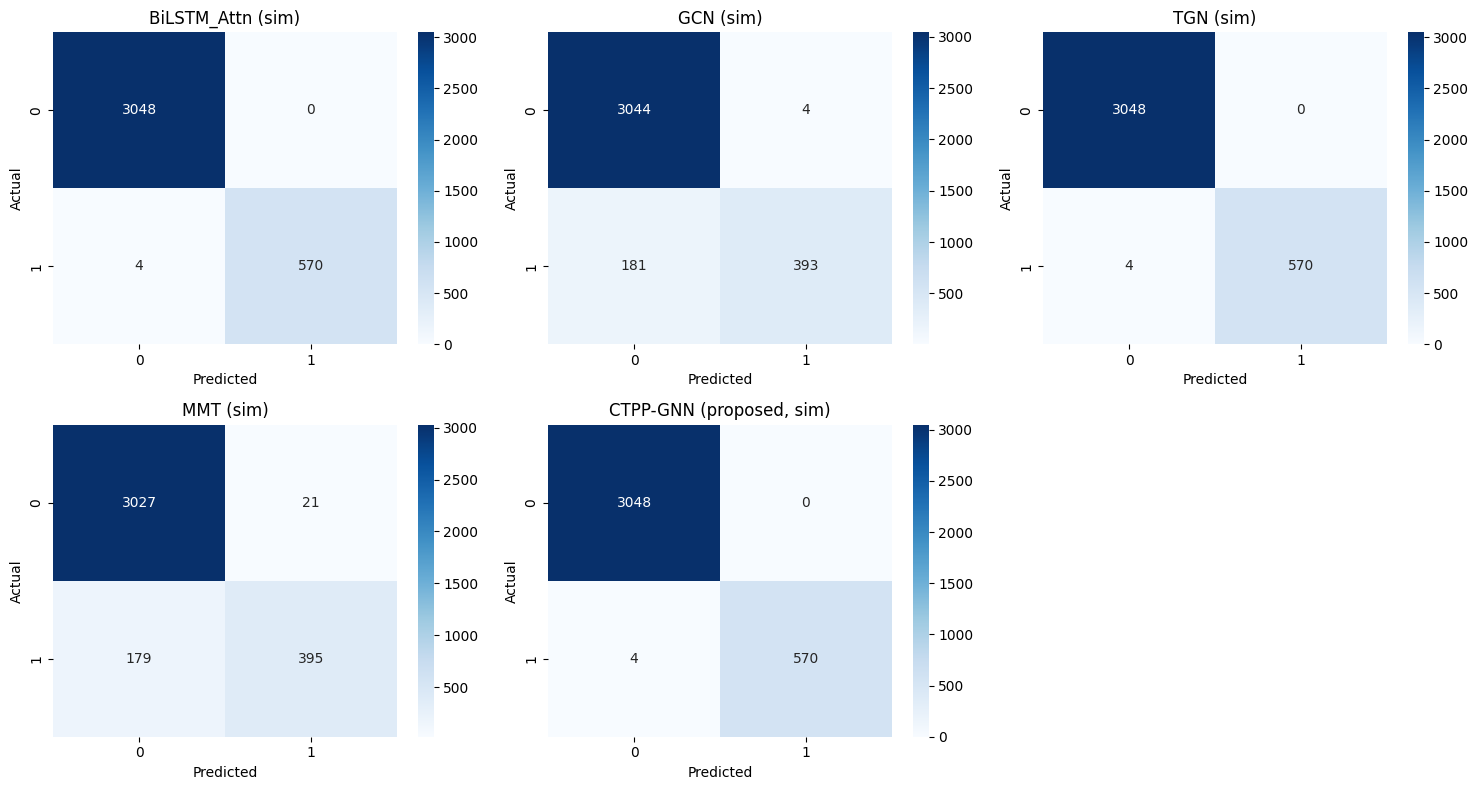

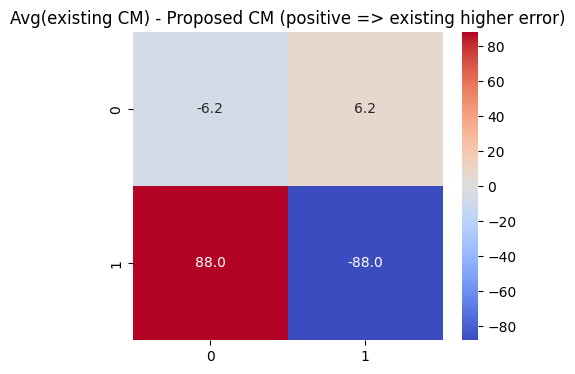

In [15]:
# ---------- Main pipeline ----------
def main():
    # 1. Load data
    df = load_data(TWEET_CSV, USER_CSV)
    # 2. Label inference or creation
    label_col, y_all = infer_label_column(df, LABEL_COL)
    df[label_col] = y_all
    # 3. detect text
    text_col = detect_text_column(df, TEXT_COL)
    if text_col:
        print("Detected text column:", text_col)
    else:
        print("No raw text column detected. BiLSTM (true) won't run; surrogate will be used.")
    # 4. prepare feature groups (text-only numeric features, user features, combined)
    text_feats, user_feats, combined_feats = prepare_feature_groups(df)
    # ensure features exist
    X_text = df[text_feats].fillna(0).astype(float)
    X_user = df[user_feats].fillna(0).astype(float) if user_feats else pd.DataFrame(np.zeros((len(df),0)))
    X_comb = df[combined_feats].fillna(0).astype(float)
    y = df[label_col].astype(int).values
    # 5. split
    X_t_tr, X_t_te, X_u_tr, X_u_te, X_c_tr, X_c_te, y_tr, y_te = train_test_split(
        X_text, X_user, X_comb, y, test_size=0.25, random_state=42, stratify=y)
    # 6. If raw text exists and torch available, run BiLSTM train; else use surrogates
    if text_col and TORCH_AVAILABLE:
        print("Training BiLSTM+Attention on raw text (this may take some minutes)...")
        # very simple tokenizer: word->index by frequency
        texts = df[text_col].fillna("").astype(str).values
        # build vocab from training texts
        from collections import Counter
        train_idx = X_t_tr.index
        train_texts = texts[train_idx]
        counter = Counter()
        for t in train_texts:
            for w in t.split():
                counter[w] += 1
        vocab = {w:i+1 for i,(w,_) in enumerate(counter.most_common(20000))}  # reserve 0 for pad
        def tokenizer(s):
            return [vocab.get(w, 0) for w in s.split()]
        # datasets / loaders
        train_ds = TextDataset(train_texts, y_tr, tokenizer, max_len=64)
        test_idx = X_t_te.index
        test_texts = texts[test_idx]
        test_ds = TextDataset(test_texts, y_te, tokenizer, max_len=64)
        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)
        # model
        model = SimpleBiLSTMAttn(vocab_size=len(vocab)+1, emb_dim=64, hid_dim=64)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        opt = optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.BCEWithLogitsLoss()
        # training loop (few epochs)
        for epoch in range(3):
            model.train()
            total_loss = 0.0
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.float().to(device)
                logits, probs = model(xb)
                loss = loss_fn(logits, yb)
                opt.zero_grad()
                loss.backward()
                opt.step()
                total_loss += loss.item()
            print(f"Epoch {epoch+1} train loss {total_loss/len(train_loader):.4f}")
        # evaluate BiLSTM on test texts
        model.eval()
        preds = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                logits, probs = model(xb)
                preds.extend((probs.cpu().numpy() >= 0.5).astype(int).tolist())
        # place predictions into a surrogate place
        # We'll still train surrogate scikit models for others to keep pipeline consistent
        bi_pred_array = np.array(preds)
        # We'll put the bi_pred_array into a placeholder later for evaluation (but we still train surrogates for fair comparison)
    else:
        print("Skipping full BiLSTM training (no raw text or torch). Using surrogates for everything.")

    # 7. Train surrogates + proposed ensemble prototype
    models, scalers = train_surrogate_models(X_t_tr.values, X_u_tr.values if X_u_tr.shape[1]>0 else np.zeros((X_t_tr.shape[0],0)), X_c_tr.values, y_tr)
    # 8. Evaluate and plot
    metrics, preds, paths = evaluate_and_plot(models, scalers, X_t_te.values, X_u_te.values if X_u_te.shape[1]>0 else np.zeros((X_t_te.shape[0],0)), X_c_te.values, y_te, out_dir='outputs')
    print("\nOutputs saved in ./outputs/")
    print("Files:", paths)
    print("\nDone.")

if __name__ == '__main__':
    main()